<a href="https://colab.research.google.com/github/marioschlosser/adventure-game-graph/blob/main/Custom_GPT_Adventure_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np

In [35]:
# @title Configure the adventure game graph

# the max number of in-links for a node from new nodes
#max_in_new = 2 # @param {type:"integer"}
# the max number of in-links for a node from existing nodes
#max_in_existing = 1 # @param {type:"integer"}

# probability distribution for in-links of a node, from new nodes
p_in_new = [0, 0.7, 0.25, 0.05] # @param {type:"raw"}

# probability distribution for in-links of a node, from existing nodes
p_in_existing = [0.7, 0.3] # @param {type:"raw"}

# total number of nodes for the graph
num_nodes_max = 10 # @param {type:"integer"}

# the number of initially accessible rooms
num_rooms_initial = 3 # @param {type:"integer"}

# the number of rooms in total
num_rooms_total = 5 # @param {type:"integer"}

def add_ancestor(node, ancestor):
    # add ancestor to node's list of ancestors, but only if it isn't already in the list
    if ancestor not in node_ancestors[node]:
        node_ancestors[node].append(ancestor)

    # compile list of out-links for this node: this is the list of nodes for which node is an in-link
    node_out = []
    for other_node in range(0, len(node_in)):
        if node in node_in[other_node]:
            node_out.append(other_node)

    # call add_ancestor for all out-links of this node
    for other_node in node_out:
        add_ancestor(other_node, ancestor)

In [36]:
# @title Initialize the puzzle graph generator

# the in-links for each node: the set of nodes that directly drive this node
node_in = [[]]
# the ancestors of each node: the set of nodes that directly and indirectly drive this node
node_ancestors = [[]]
# the room that each node is in
node_room = [0]
# the set of nodes that are rooms
rooms = []

In [37]:
# @title Create the puzzle graph

num_nodes = 0

for node in range(0, num_nodes_max):
    # generate a random number of in-links for this new node from new nodes
    num_new_in = np.random.choice(len(p_in_new), 1, p=p_in_new)[0]
    # generate a random number of in-links for this node from existing nodes
    num_existing_in = np.random.choice(len(p_in_existing), 1, p=p_in_existing)[0]

    # create range of numbers: node to node + num_new_in to new_in
    new_in = list(range(len(node_in), len(node_in) + num_new_in))

    # increase node count by newly generated nodes
    num_nodes += num_new_in

    # create the in-links lists for num_new_in nodes
    for i in range(0, num_new_in):
        node_in.append([])
        node_ancestors.append([])
        node_room.append(None)

    # add that list to the current node's in-links
    node_in[node] = new_in

    # create empty list of ancestors for this node
    node_ancestors[node] = []

    # update ancestors for this node recursively
    add_ancestor(node, node)

    # generate list of all existing nodes where node isn't an ancestor
    existing_nodes = []
    for i in range(0, node):
        if node not in node_ancestors[i]:
            existing_nodes.append(i)

    # pick num_existing_in nodes from that list randomly
    existing_in = random.sample(existing_nodes, min(num_existing_in, len(existing_nodes)))

    # add that list to the current node's in-links
    node_in[node] += existing_in

In [38]:
# show the graph
print("Here is the graph without rooms:")
print(node_in)

Here is the graph without rooms:
[[1], [2], [3], [4, 5], [6, 7], [8, 9], [10, 5], [11], [12], [13], [], [], [], []]


In [39]:
# @title Add the initially accessible rooms to the game

# create list of non-leaf nodes
non_leaf_nodes = [i for i, sublist in enumerate(node_in) if sublist]

# get the list of leaf nodes: all remaining rooms
leaf_nodes = [element for element in range(0, len(node_in)) if element not in non_leaf_nodes]

# average number of leaf nodes connected to an initial room, rounded up
avg_leaf_nodes_per_room = int(np.ceil(len(leaf_nodes) / num_rooms_initial))

# create the initial rooms and add them to the graph
for i in range(0, num_rooms_initial):
    # create new node
    node_in.append([])
    node_ancestors.append([])
    node_room.append(None)
    room = len(node_in) - 1

    # this node is a room, so its room is just itself
    node_room[room] = room

    # add to the list of rooms
    rooms.append(room)

# go through the leaf nodes and add them to the initial rooms randomly
for leaf_node in leaf_nodes:
    # pick a random initial room
    room = random.choice(rooms)

    # add the leaf node to the room
    node_in[leaf_node].append(room)
    add_ancestor(leaf_node, room)

In [40]:
# @title Add the rooms that unlock during the game

# the number of rooms to unlock during the game
num_unlocked_rooms = num_rooms_total - num_rooms_initial

# remove the final node from the list of non-leaf nodes because we can't touch it
#non_leaf_nodes.remove(0)

# pick this number of non-leaf nodes and make them rooms
for i in range(0, num_unlocked_rooms):
    # pick a random non-leaf node from the list that excludes node 0
    room = random.choice(non_leaf_nodes)

    # add the room to the list of rooms
    rooms.append(room)

    # this node is a room, so its room is just itself
    node_room[room] = room

    # remove the room from the list of non-leaf nodes
    non_leaf_nodes.remove(room)

In [41]:
# @title Link all puzzle nodes to rooms

# set all puzzle nodes to rooms
for node in range(0, len(node_in)):
    # skip nodes that are already rooms
    if node in rooms:
        continue

    # pick a room node that is in this node's ancestors
    room = random.choice([ancestor for ancestor in node_ancestors[node] if ancestor in rooms])
    # set this as this node's room
    node_room[node] = room

In [42]:
# @title Generate the room connections

# room connections for all nodes
node_connections = [[] for i in node_in]

# rooms with at least one connection: initially just the first room
rooms_with_connections = [rooms[0]]

# connect the leaf rooms to each other
for room in rooms:
    # only rooms that don't have connections yet
    if room not in rooms_with_connections:
        # pick one room among those rooms with at least one connection
        other_room = random.choice(rooms_with_connections)
        node_connections[room].append(other_room)
        node_connections[other_room].append(room)

        # add this room to the list of rooms with at least one connection
        rooms_with_connections.append(room)

# iterate through all room nodes
for room in rooms:
    # only non-leaf rooms
    if len(node_in[room]) > 0:
        # only rooms that don't have connections yet
        if room not in rooms_with_connections:
            # get the actions that unlock the room
            room_actions = node_in[room]

            # pick one of the unlocking actions at random and get the room it is in
            random_action = random.choice(room_actions)
            unlocking_room = node_room[random_action]

            # now create a connection to that room, and the other way around
            node_connections[room].append(unlocking_room)
            node_connections[unlocking_room].append(room)

In [43]:
print("Here is the graph with rooms:")
print(node_in)
print("Here are the room nodes:")
print(rooms)
print("Here is the room for each node:")
print(node_room)

# non_rooms is the set of nodes that are not rooms
non_rooms = [node for node in range(len(node_in)) if node not in rooms]

# create the node names
node_name = {node: "Room" + chr(ord('A') + rooms.index(node)) if node in rooms else "Action" + str(len(non_rooms) - non_rooms.index(node)) for node in range(len(node_in))}
# set the name for the final node
node_name[0] = "Game End"

Here is the graph with rooms:
[[1], [2], [3], [4, 5], [6, 7], [8, 9], [10, 5], [11], [12], [13], [16], [14], [14], [15], [], [], []]
Here are the room nodes:
[14, 15, 16, 8, 4]
Here is the room for each node:
[14, 8, 16, 8, 4, 15, 16, 14, 8, 15, 16, 14, 14, 15, 14, 15, 16]


In [44]:
# @title Print out the adventure game graph

print("Adventure game graph in plain text:")
for node in range(len(node_in)):
    # create list of all in-link names for this node
    node_in_names = []
    for other_node in node_in[node]:
        # only append non-rooms for conditions
        if other_node in non_rooms:
            node_in_names.append(node_name[other_node])

    required = ", ".join(node_in_names)
    required = "nothing" if required == "" else "unlocking " + required

    if node in non_rooms:
        print(f"{node_name[node]} is available in {node_name[node_room[node]]} and requires", required)
    else:
        print(f"{node_name[node]} requires", required)

print("Adventure game graph in JSON:")
# json string lists for actions and rooms
json_actions = []
json_rooms = []

# go backwards through all nodes
for node in reversed(range(len(node_in))):
    # create list of all in-link names for this node
    node_in_names = []
    for other_node in node_in[node]:
        # only append non-rooms for conditions
        if other_node in non_rooms:
            node_in_names.append(node_name[other_node])

    # concatenate node names by enclosing each in ' and separating with ,
    required = ", ".join([f"'{name}'" for name in node_in_names])

    # if room:
    if node in rooms:
        # get all the room's connections
        connections = node_connections[node]
        # concatenate room names
        connected = ", ".join([f"'{node_name[room]}'" for room in connections])

        # json string has this format: {'Room1': {'name': 'TBD', 'connected': [], 'Room1', 'required': ['Action2', 'Action3']}}
        json_rooms.append(f"'{node_name[node]}': {{'name': 'TBD', 'connected': [{connected}], 'required': [{required}]}}")
    else:
        # json string has this format: {'Action1': {'name': 'TBD', 'room': 'Room1', 'required': ['Action2', 'Action3']}}
        json_actions.append(f"'{node_name[node]}': {{'name': 'TBD', 'room': '{node_name[node_room[node]]}', 'required': [{required}]}}")

# print the json strings
print("actions_available = {")
print(",\n".join(json_actions))
print("}")
print("rooms_available = {")
print(",\n".join(json_rooms))
print("}")

Adventure game graph in plain text:
Game End is available in RoomA and requires unlocking Action11
Action11 is available in RoomD and requires unlocking Action10
Action10 is available in RoomC and requires unlocking Action9
Action9 is available in RoomD and requires unlocking Action8
RoomE requires unlocking Action7, Action6
Action8 is available in RoomB and requires unlocking Action5
Action7 is available in RoomC and requires unlocking Action4, Action8
Action6 is available in RoomA and requires unlocking Action3
RoomD requires unlocking Action2
Action5 is available in RoomB and requires unlocking Action1
Action4 is available in RoomC and requires nothing
Action3 is available in RoomA and requires nothing
Action2 is available in RoomA and requires nothing
Action1 is available in RoomB and requires nothing
RoomA requires nothing
RoomB requires nothing
RoomC requires nothing
Adventure game graph in JSON:
actions_available = {
'Action1': {'name': 'TBD', 'room': 'RoomB', 'required': []},
'

In [45]:
# @title Visualize the adventure game graph

import networkx as nx
import matplotlib.pyplot as plt
#import scipy

def draw_network(G, pos, node_color, node_shape, node_name):
    fig, ax = plt.subplots()

    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax)

    # Draw nodes with specified shapes and colors
    for (node, color), (node, shape) in zip(node_color.items(), node_shape.items()):
        # if node is a room, draw it as a square
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_shape=shape, ax=ax)

    # Draw custom labels
    nx.draw_networkx_labels(G, pos, labels=node_name, ax=ax)

    plt.axis('off')
    plt.show()

# turn lists into dict
node_room = {node: room for node, room in enumerate(node_room)}
# create dict of nodes for shape: o is for rooms, s is for puzzles
node_shape = {node: 'o' if node in rooms else 's' for node in range(len(node_in))}
# create dict of node colors
node_color = {node: plt.cm.rainbow(rooms.index(node_room[node]) / len(rooms)) for node in range(len(node_in))}

G = nx.DiGraph()
for node, links in enumerate(node_in):
    G.add_node(node)
    for target in links:
        G.add_edge(target, node)

Rooms are circles, puzzles are squares. The color of each node is the node's associated room (for puzzles: which rooms they take place in).


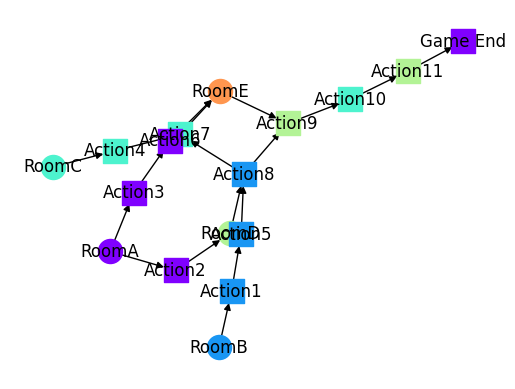

In [52]:
#pos = nx.spring_layout(G, k=0.5, iterations=50)
pos = nx.kamada_kawai_layout(G, scale=10)

# make sure the final node is at the top
#pos[0] = np.array([0, 1])
# the node y coordinate depends on the number of steps the node is away from node 0
#for node in range(1, len(node_in)):
#    pos[node] = np.array([pos[node][0], 0.1 * len(node_ancestors[node])])

# multiply all positions by 3
#pos = {node: pos[node] * 3 for node in pos}

print("Rooms are circles, puzzles are squares. The color of each node is the node's associated room (for puzzles: which rooms they take place in).")
draw_network(G, pos, node_color, node_shape, node_name)